### 3. Adam Optimizer

**Load Dataset from sklearn**

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [10]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [11]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df["Target"] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


표준 정규 분포로 정규화하기
- 데이터 스케일 조정이 필요한 경우 
 1. 분석시에 변수들의 단위 차이로 인해 숫자의 스케일이 다를 경우 
 2. 데이터셋의 값이 들쑥날쑥하거나, 매우 큰 경우에는 cost의 값이 발산하여 정상적인 학습이 이루어지지 않음

- 예시 
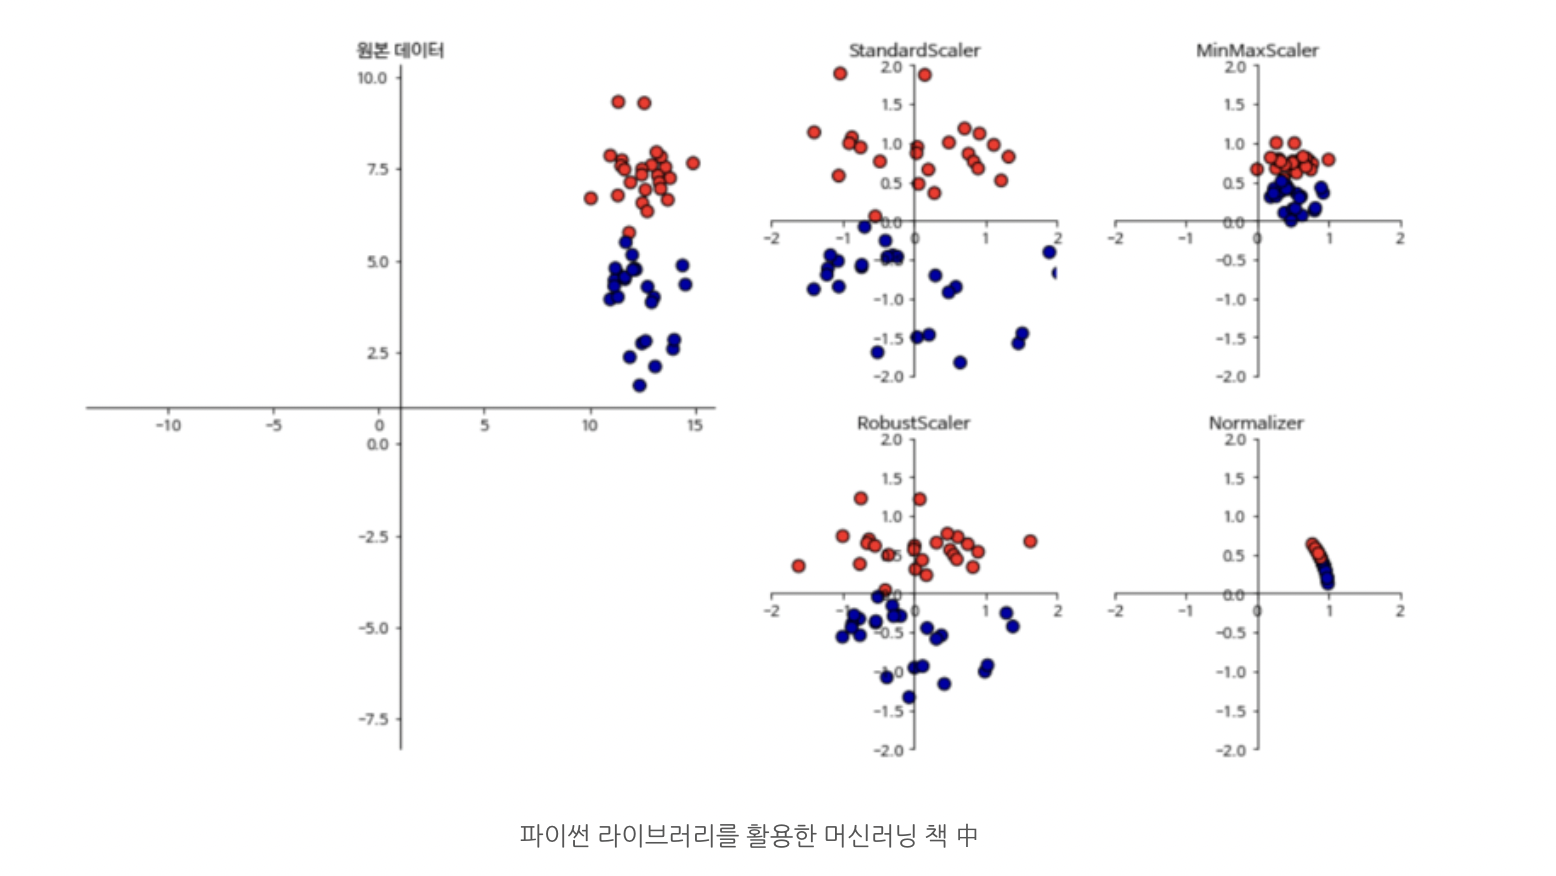

In [12]:


scaler = StandardScaler()
scaler.fit(df.values[:,:-1])
df.values[:,:-1] = scaler.transform(df.values[:, :-1])

In [13]:
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,-1.216128,-0.289187,-0.155023,0.077354,-0.512592,-0.049110,1.801647,-0.758826,0.781
20636,-0.691593,-0.845393,0.276881,0.462365,-0.944405,0.005021,1.806329,-0.818722,0.771
20637,-1.142593,-0.924851,-0.090318,0.049414,-0.369537,-0.071735,1.778237,-0.823713,0.923
20638,-1.054583,-0.845393,-0.040211,0.158778,-0.604429,-0.091225,1.778237,-0.873626,0.847
20639,-0.780129,-1.004309,-0.070443,0.138403,-0.033977,-0.043682,1.750146,-0.833696,0.894


- - - 
**Train Model with Pytorch**

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [16]:
data = torch.from_numpy(df.values).float()

data.shape

torch.Size([20640, 9])

In [22]:
x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.shape)
print(x.size(0))

torch.Size([20640, 8]) torch.Size([20640, 1])
20640


In [19]:
n_epochs = 4000
batch_size = 256
print_interval = 200
#learning_rate = 1e-2

- - -
**Build Model**

In [20]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 6), # 8->6
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),

)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [21]:
# we don't need learning rate hyper-parameter.

optimizer = optim.Adam(model.parameters())

In [27]:
# |x| = (total_size, input_dim)
# |y| = (total_size, output_dim)


for i in range(n_epochs) :
  # shuffle the index to feed-forward.
  # 20640개 데이터 셔플링해서 랜덤하게 새로 인덱스 설정해주기 
  indices = torch.randperm(x.size(0)) #x.size(0) = 20640
  x_ = torch.index_select(x, dim=0, index=indices)
  y_ = torch.index_select(y, dim=0, index=indices)

  x_ = x_.split(batch_size, dim=0)
  y_ = y_.split(batch_size, dim=0)
  # |x_[i]| = (batch_size, input_dim)
  # |y_[i]| = (batch_size, output_dim)

  y_hat = []
  total_loss = 0

  for x_i, y_i in zip(x_, y_):
    y_hat_i = model(x_i)
    loss = F.mse_loss(y_hat_i, y_i)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    total_loss += float(loss) #this is very important to prevent memory leark.
    y_hat += [y_hat_i]

  total_loss = total_loss / len(x_)
  if (i + 1) % print_interval == 0:
    print('Epoch %d : loss=%.4e' % (i+1, total_loss))

y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)



Epoch 200 : loss=3.2106e-01
Epoch 400 : loss=3.1242e-01
Epoch 600 : loss=3.1033e-01
Epoch 800 : loss=3.0857e-01
Epoch 1000 : loss=3.0962e-01
Epoch 1200 : loss=3.0924e-01
Epoch 1400 : loss=3.0863e-01
Epoch 1600 : loss=3.0853e-01
Epoch 1800 : loss=3.0775e-01
Epoch 2000 : loss=3.0869e-01
Epoch 2200 : loss=3.0788e-01
Epoch 2400 : loss=3.0796e-01
Epoch 2600 : loss=3.0720e-01
Epoch 2800 : loss=3.0640e-01
Epoch 3000 : loss=3.0750e-01
Epoch 3200 : loss=3.0724e-01
Epoch 3400 : loss=3.0727e-01
Epoch 3600 : loss=3.0765e-01
Epoch 3800 : loss=3.0691e-01
Epoch 4000 : loss=3.0700e-01


**Let's see the result!**

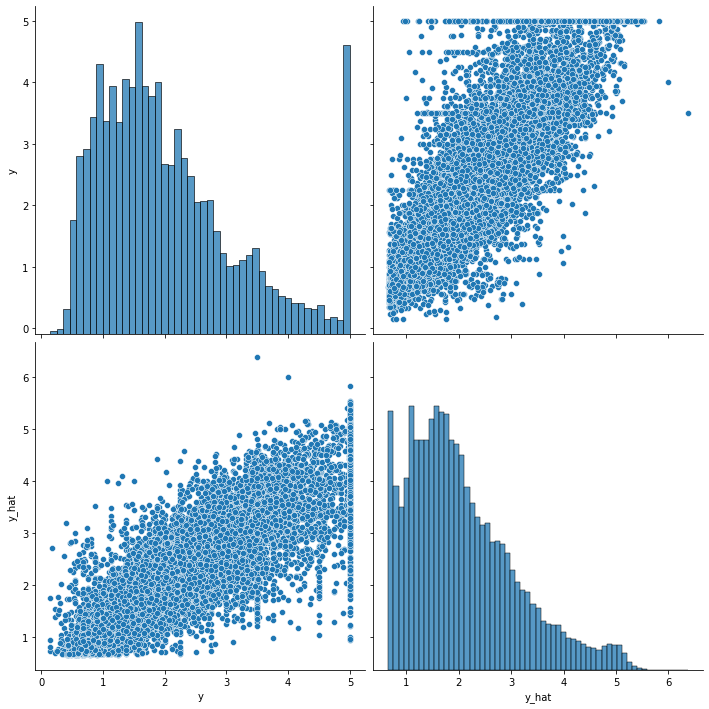

In [29]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()

# 5가 잘 예측되지 않음을 확인할 수 있다.